/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


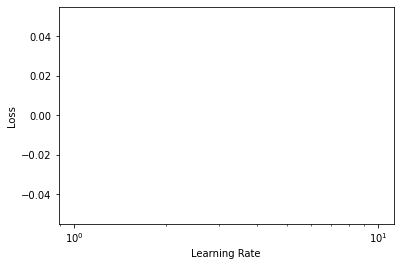

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


from fastai.vision.all import *
import fastai
import timm


# In[2]:


import torch
torch.cuda.set_device(2)


# In[3]:


from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnetrsBaselineAllPR512',monitor='cohen_kappa_score'),
    ReduceLROnPlateau(patience=2)
]


# In[4]:


dfValid = pd.read_csv('../dr_kaggle_and_ics_dataset_split_training.csv')


# In[5]:




# In[6]:


dfValid


# In[7]:


kwownFiles = []
for x in dfValid.image_id:
    if((os.path.exists('../images/transformed_512x512_color_rgb_filter_none/'+x))):
        kwownFiles.append(x)


# In[8]:


dfKeep = dfValid[dfValid['image_id'].isin(kwownFiles)]


# In[9]:


dfValid = dfKeep

# In[10]:


def dr_extended_to_aptos(x):
    if(x=='normal'):
        return 0
    if(x=='leve'):
        return 1
    if(x=='moderada'):
        return 2
    if(x=='severa'):
        return 3
    if(x=='proliferativa'):
        return 4
    else:
        return 5


# In[11]:


dfValid['aptos']=dfValid['dr_extended'].apply(lambda x: dr_extended_to_aptos(x))


# In[12]:


dfValid

def is_valid(path):
    name = path[0]
    return (dfValid[dfValid['image_id']==name])['split'].values[0]=='validation'
# In[13]:


dbTrain3 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(0,pref="../images/transformed_512x512_color_rgb_filter_none/"),
                 get_y=ColReader(6),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])


# In[14]:


dlsTrain3 = dbTrain3.dataloaders(dfValid.values,bs=8,num_workers=0)


# In[15]:



learn = Learner(dlsTrain3,timm.create_model('resnetrs50',num_classes=6,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,CohenKappa(weights='quadratic')],cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()


# In[16]:


learn.load('resnetrsBaselineAllPR384D05')


# In[17]:


learn.freeze()
learn.lr_find()



SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=1.3182567499825382e-06)

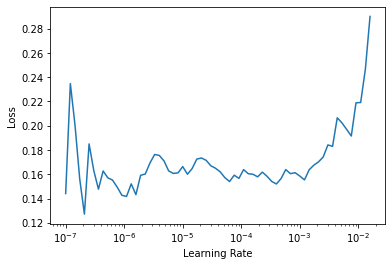

In [3]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,0.150212,0.168406,0.887312,0.726203,52:36


Better model found at epoch 0 with cohen_kappa_score value: 0.7262032842842283.


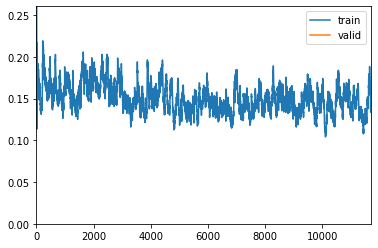

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,0.120051,0.168736,0.887693,0.729170,52:04
1,0.169623,0.166910,0.886740,0.730894,50:51
2,0.118522,0.164735,0.887883,0.725987,54:15
3,0.134448,0.163628,0.886836,0.733005,1:06:38
4,0.139466,0.163248,0.888455,0.735112,1:05:51
5,0.133007,0.166111,0.887883,0.731966,1:02:24
6,0.130236,0.163404,0.885788,0.738127,1:04:00
7,0.142084,0.164114,0.887312,0.738295,1:03:23
8,0.142358,0.162103,0.887407,0.729705,1:03:30
9,0.133803,0.161397,0.887693,0.743289,1:03:04


Better model found at epoch 0 with cohen_kappa_score value: 0.7291700484366728.


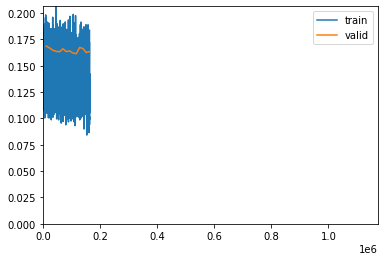

Better model found at epoch 1 with cohen_kappa_score value: 0.7308940891896087.
Better model found at epoch 3 with cohen_kappa_score value: 0.7330047798994441.
Better model found at epoch 4 with cohen_kappa_score value: 0.7351120463127883.
Better model found at epoch 6 with cohen_kappa_score value: 0.7381273386515692.
Epoch 6: reducing lr to 4.541094974292777e-08
Better model found at epoch 7 with cohen_kappa_score value: 0.7382946701840751.
Better model found at epoch 9 with cohen_kappa_score value: 0.7432893193768602.
Epoch 11: reducing lr to 7.145846851139753e-08
Better model found at epoch 12 with cohen_kappa_score value: 0.7454383096955512.
Epoch 13: reducing lr to 8.372775624081619e-08
No improvement since epoch 9: early stopping


In [4]:
# In[ ]:


learn.fine_tune(100,base_lr=3e-6,wd=1e-3)